In [0]:
import networkx as nx
import matplotlib.pyplot as plt

from functools import reduce
from graphframes import GraphFrame
from pyspark.sql.functions import col, lit

In [0]:
vertices = spark.createDataFrame([("NYC", "New York City", 103),
                                  ("EUG", "Eugene", 65),
                                  ("AMW", "Ames", 35),
                                  ("AUS", "Austin", 46),
                                  ("BOS", "Boston", 57),
                                  ("SEA", "Seattle", 10),
                                  ("SFO", "San Francisco", 10),
                                  ("RDM", "Bend", 70),
                                  ("PDX", "Portland", 3)], ["id", "airport_name", "total_flights"])

In [0]:
edges = spark.createDataFrame([("NYC", "EUG", 33, 240),
                               ("EUG", "AMW", -10, 100),
                               ("AMW", "EUG", 0, 110),
                               ("PDX", "AMW", 0, 120),
                               ("BOS", "NYC", 44, 150),
                               ("NYC", "BOS", 18, 160),
                               ("NYC", "SFO", 9, 270),
                               ("AUS", "PDX", -5, 180),
                               ("BOS", "PDX", 3, 280),
                               ("RDM", "PDX", -2, 80),
                               ("SEA", "SFO", 5, 110),
                               ("RDM", "SEA", 10, 150),
                               ("SEA", "NYC", 35, 290),
                               ("SFO", "RDM", 25, 300)], ["src", "dst", "delay", "airtime"])

In [0]:
flight_routes = GraphFrame(vertices, edges)

In [0]:
def plot_directed_graph(gf, relationship):
  
  gplot = nx.DiGraph()
  edge_labels = {}
  
  plt.figure(figsize=(6, 7))
  for node in gf.vertices.select('id').take(1000):
    gplot.add_node(node['id'])
 
  for row in gf.edges.select('src', 'dst', relationship).take(1000):
    gplot.add_edge(row['src'], row['dst'])
    edge_labels[(row['src'], row['dst'])] = row[relationship]
       
  pos = nx.shell_layout(gplot)
  
  nx.draw(gplot,
          pos,
          with_labels=True, 
          font_weight='bold', 
          node_size=1800, 
          font_size=15, 
          width=2)
    
  nx.draw_networkx_edge_labels(gplot,
                               pos,
                               edge_labels=edge_labels,
                               font_color='green',
                               font_size=10,
                               font_weight='bold')

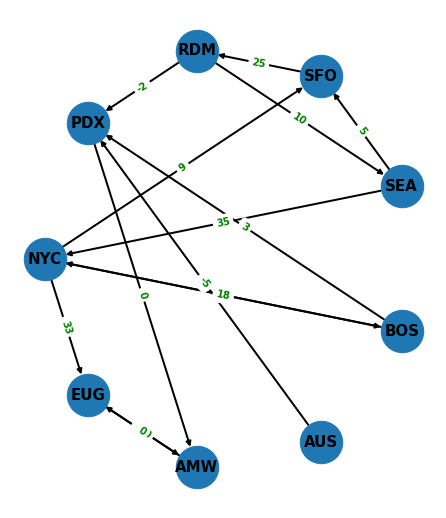

In [0]:
plot_directed_graph(flight_routes, 'delay')

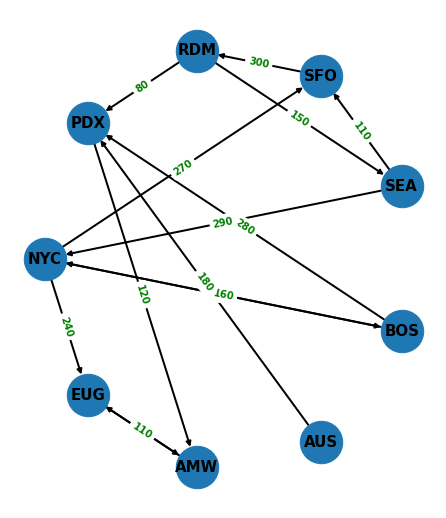

In [0]:
plot_directed_graph(flight_routes, 'airtime')

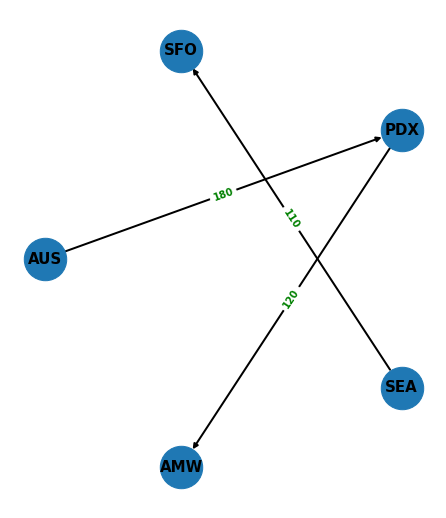

In [0]:
# SubGraph is a filtered representation
not_busy_airports_short_flights = flight_routes.filterVertices('total_flights < 50')\
                                               .filterEdges('airtime < 200')\
                                               .dropIsolatedVertices()

plot_directed_graph(not_busy_airports_short_flights, 'airtime')

In [0]:
direct_routes = flight_routes.find("(source)-[edge]->(destination)")

direct_routes.display()

source,edge,destination
"List(NYC, New York City, 103)","List(NYC, EUG, 33, 240)","List(EUG, Eugene, 65)"
"List(AMW, Ames, 35)","List(AMW, EUG, 0, 110)","List(EUG, Eugene, 65)"
"List(SEA, Seattle, 10)","List(SEA, NYC, 35, 290)","List(NYC, New York City, 103)"
"List(BOS, Boston, 57)","List(BOS, NYC, 44, 150)","List(NYC, New York City, 103)"
"List(PDX, Portland, 3)","List(PDX, AMW, 0, 120)","List(AMW, Ames, 35)"
"List(EUG, Eugene, 65)","List(EUG, AMW, -10, 100)","List(AMW, Ames, 35)"
"List(NYC, New York City, 103)","List(NYC, BOS, 18, 160)","List(BOS, Boston, 57)"
"List(RDM, Bend, 70)","List(RDM, SEA, 10, 150)","List(SEA, Seattle, 10)"
"List(SFO, San Francisco, 10)","List(SFO, RDM, 25, 300)","List(RDM, Bend, 70)"
"List(RDM, Bend, 70)","List(RDM, PDX, -2, 80)","List(PDX, Portland, 3)"


In [0]:
direct_routes.filter('edge.airtime > 120')\
             .filter('edge.delay > 10')\
             .filter('source.total_flights > destination.total_flights').display()

source,edge,destination
"List(NYC, New York City, 103)","List(NYC, EUG, 33, 240)","List(EUG, Eugene, 65)"
"List(NYC, New York City, 103)","List(NYC, BOS, 18, 160)","List(BOS, Boston, 57)"
